# DNN 정형데이터 템플릿 - 회귀(연속값) 완전체
시험장에서 **컬럼명만 바꾸고 복붙**해서 바로 돌릴 수 있게 만든 3교시용 템플릿입니다.

## 🎯 공통 평가 포인트(출제 의도)
- 데이터 탐색(결측/분포/불균형) → 전처리(범주/수치) → DNN 학습 → 지표 평가 → (분류면) 운영 정책/리포트
- 과적합 방지(드롭아웃/weight decay/validation)
- (가산) 간단 해석(오차 상위 샘플/Confusion matrix/정책 기반 리포트)

## ✅ 시험장에서 바꾸는 곳(필수 3개)
- `CSV_PATH` (토이데이터 대신 실제 CSV)
- `target_col`
- `cat_cols` (범주형 리스트)
나머지는 거의 그대로 사용 가능.


## 0) Imports & 재현성

In [ ]:
import os, random, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) 토이데이터 생성 (회귀)
예시 컨셉: 제조 공정 변수로 **연속값 KPI(예: cycle_time, yield_loss, energy_usage)** 예측

- 범주형: line_id, shift, supplier, material_grade
- 수치형: 온도/압력/진동/에러 등
- 타깃: `target_y` (연속값)
- 포함 요소: 결측 + 이상치(heavy tail)


In [ ]:
def make_toy_regression(n=20000, seed=42):
    rng = np.random.default_rng(seed)
    line_id = rng.integers(1, 7, size=n).astype(str)
    shift = rng.choice(["day","swing","night"], size=n, p=[0.5,0.3,0.2])
    supplier = rng.choice(["A","B","C","D","E"], size=n, p=[0.25,0.25,0.2,0.2,0.1])
    material_grade = rng.choice(["G1","G2","G3"], size=n, p=[0.55,0.35,0.10])

    temp = rng.normal(70, 5, size=n) + (line_id.astype(int)-3)*0.7
    pressure = np.abs(rng.normal(1.1, 0.35, size=n))
    vibration = np.abs(rng.normal(3.0, 1.0, size=n)) + (shift=="night")*0.6
    humidity = np.clip(rng.normal(45, 10, size=n), 10, 90)
    error_cnt = rng.poisson(1.3, size=n) + (supplier=="E")*1

    y = (
        120
        + 0.35*(temp-70)
        + 4.0*np.sqrt(pressure)
        + 2.2*np.log1p(vibration)
        + 1.6*error_cnt
        + (material_grade=="G3")*6
        + ((supplier=="C") & (shift=="night"))*4
        + rng.normal(0, 3.0, size=n)
    )

    df = pd.DataFrame({
        "line_id": line_id,
        "shift": shift,
        "supplier": supplier,
        "material_grade": material_grade,
        "temp": temp,
        "pressure": pressure,
        "vibration": vibration,
        "humidity": humidity,
        "error_cnt": error_cnt,
        "target_y": y
    })

    for col in ["temp","pressure","humidity"]:
        m = rng.random(n) < 0.02
        df.loc[m, col] = np.nan

    o = rng.random(n) < 0.005
    df.loc[o, "target_y"] += rng.normal(30, 8, o.sum())
    return df

df = make_toy_regression()
df.head()


,line_id,shift,supplier,material_grade,temp,pressure,vibration,humidity,error_cnt,target_y
0,1,swing,B,G2,73.168503,0.876834,4.762998,36.643940,0,133.469402
1,5,swing,B,G1,59.481520,1.511594,3.343818,49.100940,1,129.313944
2,4,day,E,G2,68.842233,0.781406,2.808230,49.216298,3,131.985922
3,3,day,A,G1,67.952355,1.244450,2.125842,38.328802,2,129.488953
4,3,day,A,G1,67.677732,0.856918,3.649270,44.314638,1,124.509538


## 2) 데이터 탐색(EDA): 크기/결측/타깃 분포

Shape: (20000, 10)

Missing ratio top:
temp              0.02030
pressure          0.01995
humidity          0.01960
line_id           0.00000
shift             0.00000
material_grade    0.00000
supplier          0.00000
vibration         0.00000
error_cnt         0.00000
target_y          0.00000
dtype: float64


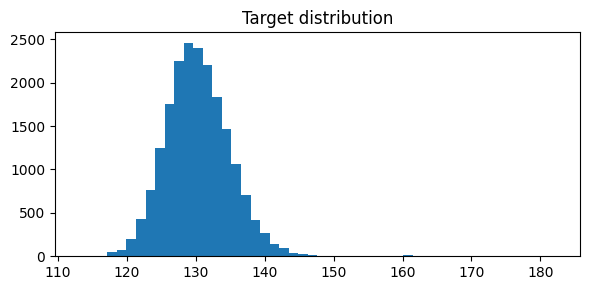

In [ ]:
target_col = "target_y"
cat_cols = ["line_id","shift","supplier","material_grade"]
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print("Shape:", df.shape)
print("\nMissing ratio top:")
print(df.isna().mean().sort_values(ascending=False).head(10))

plt.figure(figsize=(6,3))
plt.hist(df[target_col].dropna(), bins=50)
plt.title("Target distribution")
plt.tight_layout()
plt.show()


## 3) Split & 전처리(범주형/수치형)

In [ ]:
X = df[cat_cols + num_cols].copy()
y = df[target_col].copy()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

USE_ROBUST = True
scaler = RobustScaler() if USE_ROBUST else StandardScaler()

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", scaler)
])
preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols),
])

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc = preprocess.transform(X_val)

X_train_dense = X_train_enc.toarray() if hasattr(X_train_enc, "toarray") else np.asarray(X_train_enc)
X_val_dense = X_val_enc.toarray() if hasattr(X_val_enc, "toarray") else np.asarray(X_val_enc)

print("Dense shapes:", X_train_dense.shape, X_val_dense.shape)


Dense shapes: (16000, 22) (4000, 22)


## 4) PyTorch Dataset/DataLoader

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train_dense, y_train)
val_ds = TabularDataset(X_val_dense, y_val)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)


## 5) DNN 모델 + 손실/가중치(불균형 대응)

In [ ]:
in_dim = X_train_dense.shape[1]
out_dim = 1

class DNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_dim),
        )
    def forward(self, x):
        return self.net(x)

model = DNN(in_dim, out_dim).to(device)

criterion = nn.MSELoss()  # 대안: nn.L1Loss(), nn.HuberLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


## 6) 학습/평가 루프

In [ ]:
def eval_val():
    model.eval()
    val_loss = 0.0
    n = 0
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            yhat = model(xb)
            loss = criterion(yhat, yb)
            val_loss += loss.item() * len(xb)
            n += len(xb)
            preds.append(yhat.cpu().numpy())
            trues.append(yb.cpu().numpy())
    pred = np.vstack(preds).ravel()
    true = np.vstack(trues).ravel()
    mae = np.mean(np.abs(true - pred))
    rmse = math.sqrt(np.mean((true - pred)**2))
    return val_loss / n, mae, rmse

best_mae = 1e18
best_state = None
EPOCHS = 25

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss = 0.0
    n = 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * len(xb)
        n += len(xb)

    val_loss, mae, rmse = eval_val()
    if mae < best_mae:
        best_mae = mae
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | train_loss {tr_loss/n:.4f} | val_loss {val_loss:.4f} | MAE {mae:.4f} | RMSE {rmse:.4f}")

model.load_state_dict(best_state)
print("Best MAE:", best_mae)


epoch 01 | train_loss 15403.6285 | val_loss 11448.3841 | MAE 106.8746 | RMSE 106.9971
epoch 05 | train_loss 227.4389 | val_loss 22.6048 | MAE 3.4020 | RMSE 4.7544
epoch 10 | train_loss 212.3658 | val_loss 19.6084 | MAE 3.1686 | RMSE 4.4281
epoch 15 | train_loss 209.3436 | val_loss 18.0115 | MAE 3.0097 | RMSE 4.2440
epoch 20 | train_loss 203.2282 | val_loss 19.3546 | MAE 3.1578 | RMSE 4.3994
epoch 25 | train_loss 205.7165 | val_loss 16.0495 | MAE 2.8070 | RMSE 4.0062
Best MAE: 2.7430933


## 7) 회귀 출력(필수): MAE/RMSE + 오차 Top 샘플

In [ ]:
# 최종 예측/리포트
model.eval()
with torch.no_grad():
    pred = model(torch.tensor(X_val_dense, dtype=torch.float32, device=device)).cpu().numpy().ravel()
true = y_val.values.astype(float)

mae = np.mean(np.abs(true - pred))
rmse = math.sqrt(np.mean((true - pred)**2))
print("MAE:", mae, "RMSE:", rmse)

val_report = X_val.copy()
val_report["y_true"] = true
val_report["y_pred"] = pred
val_report["abs_error"] = np.abs(true - pred)
val_report.sort_values("abs_error", ascending=False).head(30)


MAE: 2.7430931433649635 RMSE: 3.948336887470832


,line_id,shift,supplier,material_grade,temp,pressure,vibration,humidity,error_cnt,y_true,y_pred,abs_error
19391,3,night,E,G1,64.363268,0.757956,3.955863,35.825188,2,173.755001,128.400375,45.354626
4991,4,day,C,G1,72.652029,1.586707,2.744235,27.948234,1,169.275467,130.203598,39.071869
16969,5,day,E,G1,76.133784,0.542134,1.887080,27.027932,2,167.593290,129.865448,37.727842
2039,3,swing,D,G1,70.892082,0.867812,2.447788,47.919498,0,163.296810,125.584419,37.712391
7668,2,swing,D,G1,71.503097,1.181607,2.362264,44.568315,2,166.362489,130.356155,36.006334
11596,4,swing,D,G1,79.762892,1.322644,4.110104,56.681778,0,164.711679,130.310654,34.401025
18464,5,day,B,G2,67.915618,1.235252,2.966914,43.464256,1,160.665574,127.106773,33.558800
17670,3,day,B,G3,73.250598,1.140906,2.546858,46.026893,1,166.989518,134.220535,32.768983
14739,6,day,B,G1,75.759172,0.697622,1.976631,32.179694,1,160.276571,127.983284,32.293287
9125,2,night,C,G3,61.700810,1.117438,2.132644,35.686318,4,170.821017,138.774628,32.046390


## 8) 시험장 복붙 체크리스트(초압축)
1) `CSV_PATH` 로딩 → `target_col`, `cat_cols` 지정  
2) `num_cols` 자동 생성 확인  
3) 전처리(OHE+Scaler) → dense 변환  
4) DNN 학습(Adam + dropout + weight_decay)  
5) 회귀: MAE/RMSE / 이진: PR-AUC+임계값 / 다중: macroF1+confusion  
6) 리포트 출력(TopN/오차상위/확신상위)까지 하면 점수 잘 나옴
